In [727]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from numpy import random
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')

#### Dataset

In [2]:
df=pd.read_csv("C:/Users/( ^_^ )/OneDrive/Desktop/Udacity projects/example-project/Example Project/diamonds.csv")

In [3]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [4]:
df.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


## Cleaning dataset

In [6]:
#checking the corelation between the target variable and the other numerical columns
corr = df.corr().sort_values(by='price', ascending=False)[['price']]
corr

,price
price,1.000000
carat,0.921591
x,0.884435
y,0.865421
z,0.861249
table,0.127134
depth,-0.010647


Carat (size of the diamond) have the highest corelation. We will put this into consideration as the only numeric variable we will use

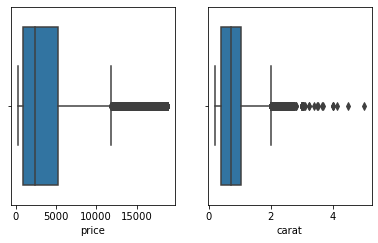

In [7]:
#checking for outliers
figures=1
numeric_var=['price', 'carat']
plt.figure(figsize=(10,8))
for var in numeric_var:
    plt.subplot(2,3,figures)
    sns.boxplot(x=df[var])
    figures+=1
plt.show()

We can confirm there are outliers associated with both price and carat

In [8]:
#function to remove outliers
def remove_outlier(column):
    p25 = column.describe()[4]
    p75 = column.describe()[6]
    IQR = p75 - p25
    ul = p75 + 1.5*IQR
    ll = p25 - 1.5*IQR
    column.mask(column>ul,ul,inplace=True)
    column.mask(column<ll,ll,inplace=True)

In [9]:
#Remove outliers associated with carat and price
remove_outlier(df.carat)
remove_outlier(df.price)

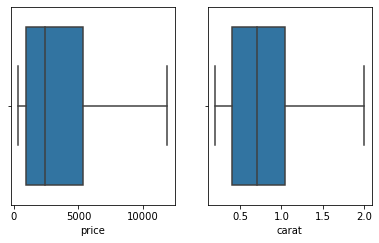

In [10]:
#checking again for outliers
figures=1
numeric_var=['price', 'carat']
plt.figure(figsize=(10,8))
for var in numeric_var:
    plt.subplot(2,3,figures)
    sns.boxplot(x=df[var])
    figures+=1
plt.show()

We can now confirm there are no outliers with all of our numeric variables

In [178]:
#Encoding categories to numeric for color, cut and clarity 
df['cut_factors']=df['cut'].astype('category').cat.codes
df['color_factors']=df['color'].astype('category').cat.codes
df['clarity_factors']=df['clarity'].astype('category').cat.codes

In [179]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z,cut_factors,color_factors,clarity_factors
0,0.23,Ideal,E,SI2,61.5,55.0,326.0,3.95,3.98,2.43,2,1,3
1,0.21,Premium,E,SI1,59.8,61.0,326.0,3.89,3.84,2.31,3,1,2
2,0.23,Good,E,VS1,56.9,65.0,327.0,4.05,4.07,2.31,1,1,4
3,0.29,Premium,I,VS2,62.4,58.0,334.0,4.20,4.23,2.63,3,5,5
4,0.31,Good,J,SI2,63.3,58.0,335.0,4.34,4.35,2.75,1,6,3


In [13]:
df.cut.unique()

array(['Ideal', 'Premium', 'Good', 'Very Good', 'Fair'], dtype=object)

In [14]:
df.cut_factors.unique()

array([2, 3, 1, 4, 0], dtype=int8)

In [180]:
df.color.unique()

array(['E', 'I', 'J', 'H', 'F', 'G', 'D'], dtype=object)

In [181]:
df.color_factors.unique()

array([1, 5, 6, 4, 2, 3, 0], dtype=int8)

In [182]:
df.clarity.unique()

array(['SI2', 'SI1', 'VS1', 'VS2', 'VVS2', 'VVS1', 'I1', 'IF'],
      dtype=object)

In [183]:
df.clarity_factors.unique()

array([3, 2, 4, 5, 7, 6, 0, 1], dtype=int8)

In [761]:
#A function to understand each encoding
def encoding_value(value,column):
    if column=='color':
        print (df[df['color']==value].color_factors.unique())
    elif column=='cut':
        print( df[df['cut']==value].cut_factors.unique())
    elif column=='clarity':
        print(df[df['clarity']==value].clarity_factors.unique())


In [762]:
encoding_value('Premium','cut')

[3]


In [763]:
encoding_value('E','color')

[1]


In [760]:
encoding_value('IF','clarity')

[1]


# Splitting the data and creating model

In [490]:
x = df.iloc[:,[0,10,11,12]]
y = df.iloc[:,-7]

In [491]:
y.head()

0    326.0
1    326.0
2    327.0
3    334.0
4    335.0
Name: price, dtype: float64

In [492]:
x.head()

,carat,cut_factors,color_factors,clarity_factors
0,0.23,2,1,3
1,0.21,3,1,2
2,0.23,1,1,4
3,0.29,3,5,5
4,0.31,1,6,3


We focus on predicting the price of diamond from carat(Weight), cut, its color and the clarity

In [493]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=30, test_size=0.2)

In [494]:
# creating 4 different models
RF = RandomForestRegressor().fit(x_train, y_train)
DT = DecisionTreeRegressor().fit(x_train, y_train)
GBR = GradientBoostingRegressor().fit(x_train, y_train)
LR = LinearRegression().fit(x_train, y_train)


In [495]:
# the evaluation metrics
models = [LR, DT, RF, GBR]
RMSE = [mean_squared_error(y_test, mod.predict(x_test))**0.5 for mod in models]
MAPE = [mean_absolute_percentage_error(y_test, mod.predict(x_test)) for mod in models]
R2_Score = [r2_score(y_test, mod.predict(x_test)) for mod in models]

In [496]:
# comparing 4 models
Models = ['Linear Regression','Decision Tree','Random Forest','Gradient Boosting']
evaluation = pd.DataFrame({'Models':Models,'RMSE':RMSE,'MAPE':MAPE, 'R2_Score':R2_Score})

In [497]:
evaluation 

,Models,RMSE,MAPE,R2_Score
0,Linear Regression,1066.343138,0.357349,0.903906
1,Decision Tree,442.782765,0.080538,0.983432
2,Random Forest,411.863116,0.077192,0.985665
3,Gradient Boosting,492.528258,0.103785,0.979500


#### We got highest R2_score from Random Forest model

# Making the model As function  

In [498]:
Colorless=[0,1,2]
Near_colorless=[3,4,5,6]

In [764]:
def Price_of_diamond(cut,color,weight,clarity):
    if color=='colorless':
        color_factors=random.choice(Colorless)
        test=[df[df['cut']==cut].cut_factors.unique(),color_factors,weight,df[df['clarity']==clarity].clarity_factors.unique()]
        test=(np.array(test)).reshape(1,-1)
        Price=RF.predict(test)
        for price in Price:
            print("Price of this diamond is: $",int(price))
        
    elif color=='Near colorless':
        color_factors=random.choice(Near_colorless)
        test=[df[df['cut']==cut].cut_factors.unique(),color_factors,weight,df[df['clarity']==clarity].clarity_factors.unique()]
        test=(np.array(test)).reshape(1,-1)
        Price=RF.predict(test)
        for price in Price:
            print("Price of this diamond is: $",int(price))
        

In [813]:
Price_of_diamond('Fair','Near colorless',0.01,'VVS2')

Price of this diamond is: $ 680
